# Create the baseline results

In [89]:
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from src.utils.old_features import (
    DurationExtractor,
    read_lab_file,
    get_duration_features_from_lab_root,
)
from src.data.components.datasets import TokenTaggingDataset

In [71]:
LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/train-clean-360"
WAV_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS/train-clean-360"
CACHE_DIR = "/Users/lukas/Desktop/projects/MIT/data/cache/"

## Load data via torch dataset

In [72]:
from transformers import GPT2Tokenizer

# only to create a valid dataset
dummy_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_special_tokens=True)

In [73]:
DATA_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki"
SAVE_DIR = (
    "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/duration"
)

In [74]:
from src.data.components.feature_extractors import DurationFeatureExtractor

feature_extractor = DurationFeatureExtractor(
    lab_root=LAB_ROOT, wav_root=WAV_ROOT, data_cache=CACHE_DIR
)

Searching for features from /Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/train-clean-360...
Loaded 108321 samples from cache.
Finished extracting 108321 samples.


In [75]:
texts = feature_extractor.get_all_texts()
words = [word for txt in texts for word in txt.split(" ")]
durations = feature_extractor.get_all_durations()
durations = [
    word_duration
    for sentence_durations in durations
    for word_duration in sentence_durations
]
len(words), len(durations)

(1900198, 1900198)

In [76]:
GLOBAL_MEAN_DURATION = np.mean(durations)
GLOBAL_STD_DURATION = np.std(durations)
GLOBAL_MEAN_DURATION, GLOBAL_STD_DURATION

(0.2965767672632011, 0.17948863134473267)

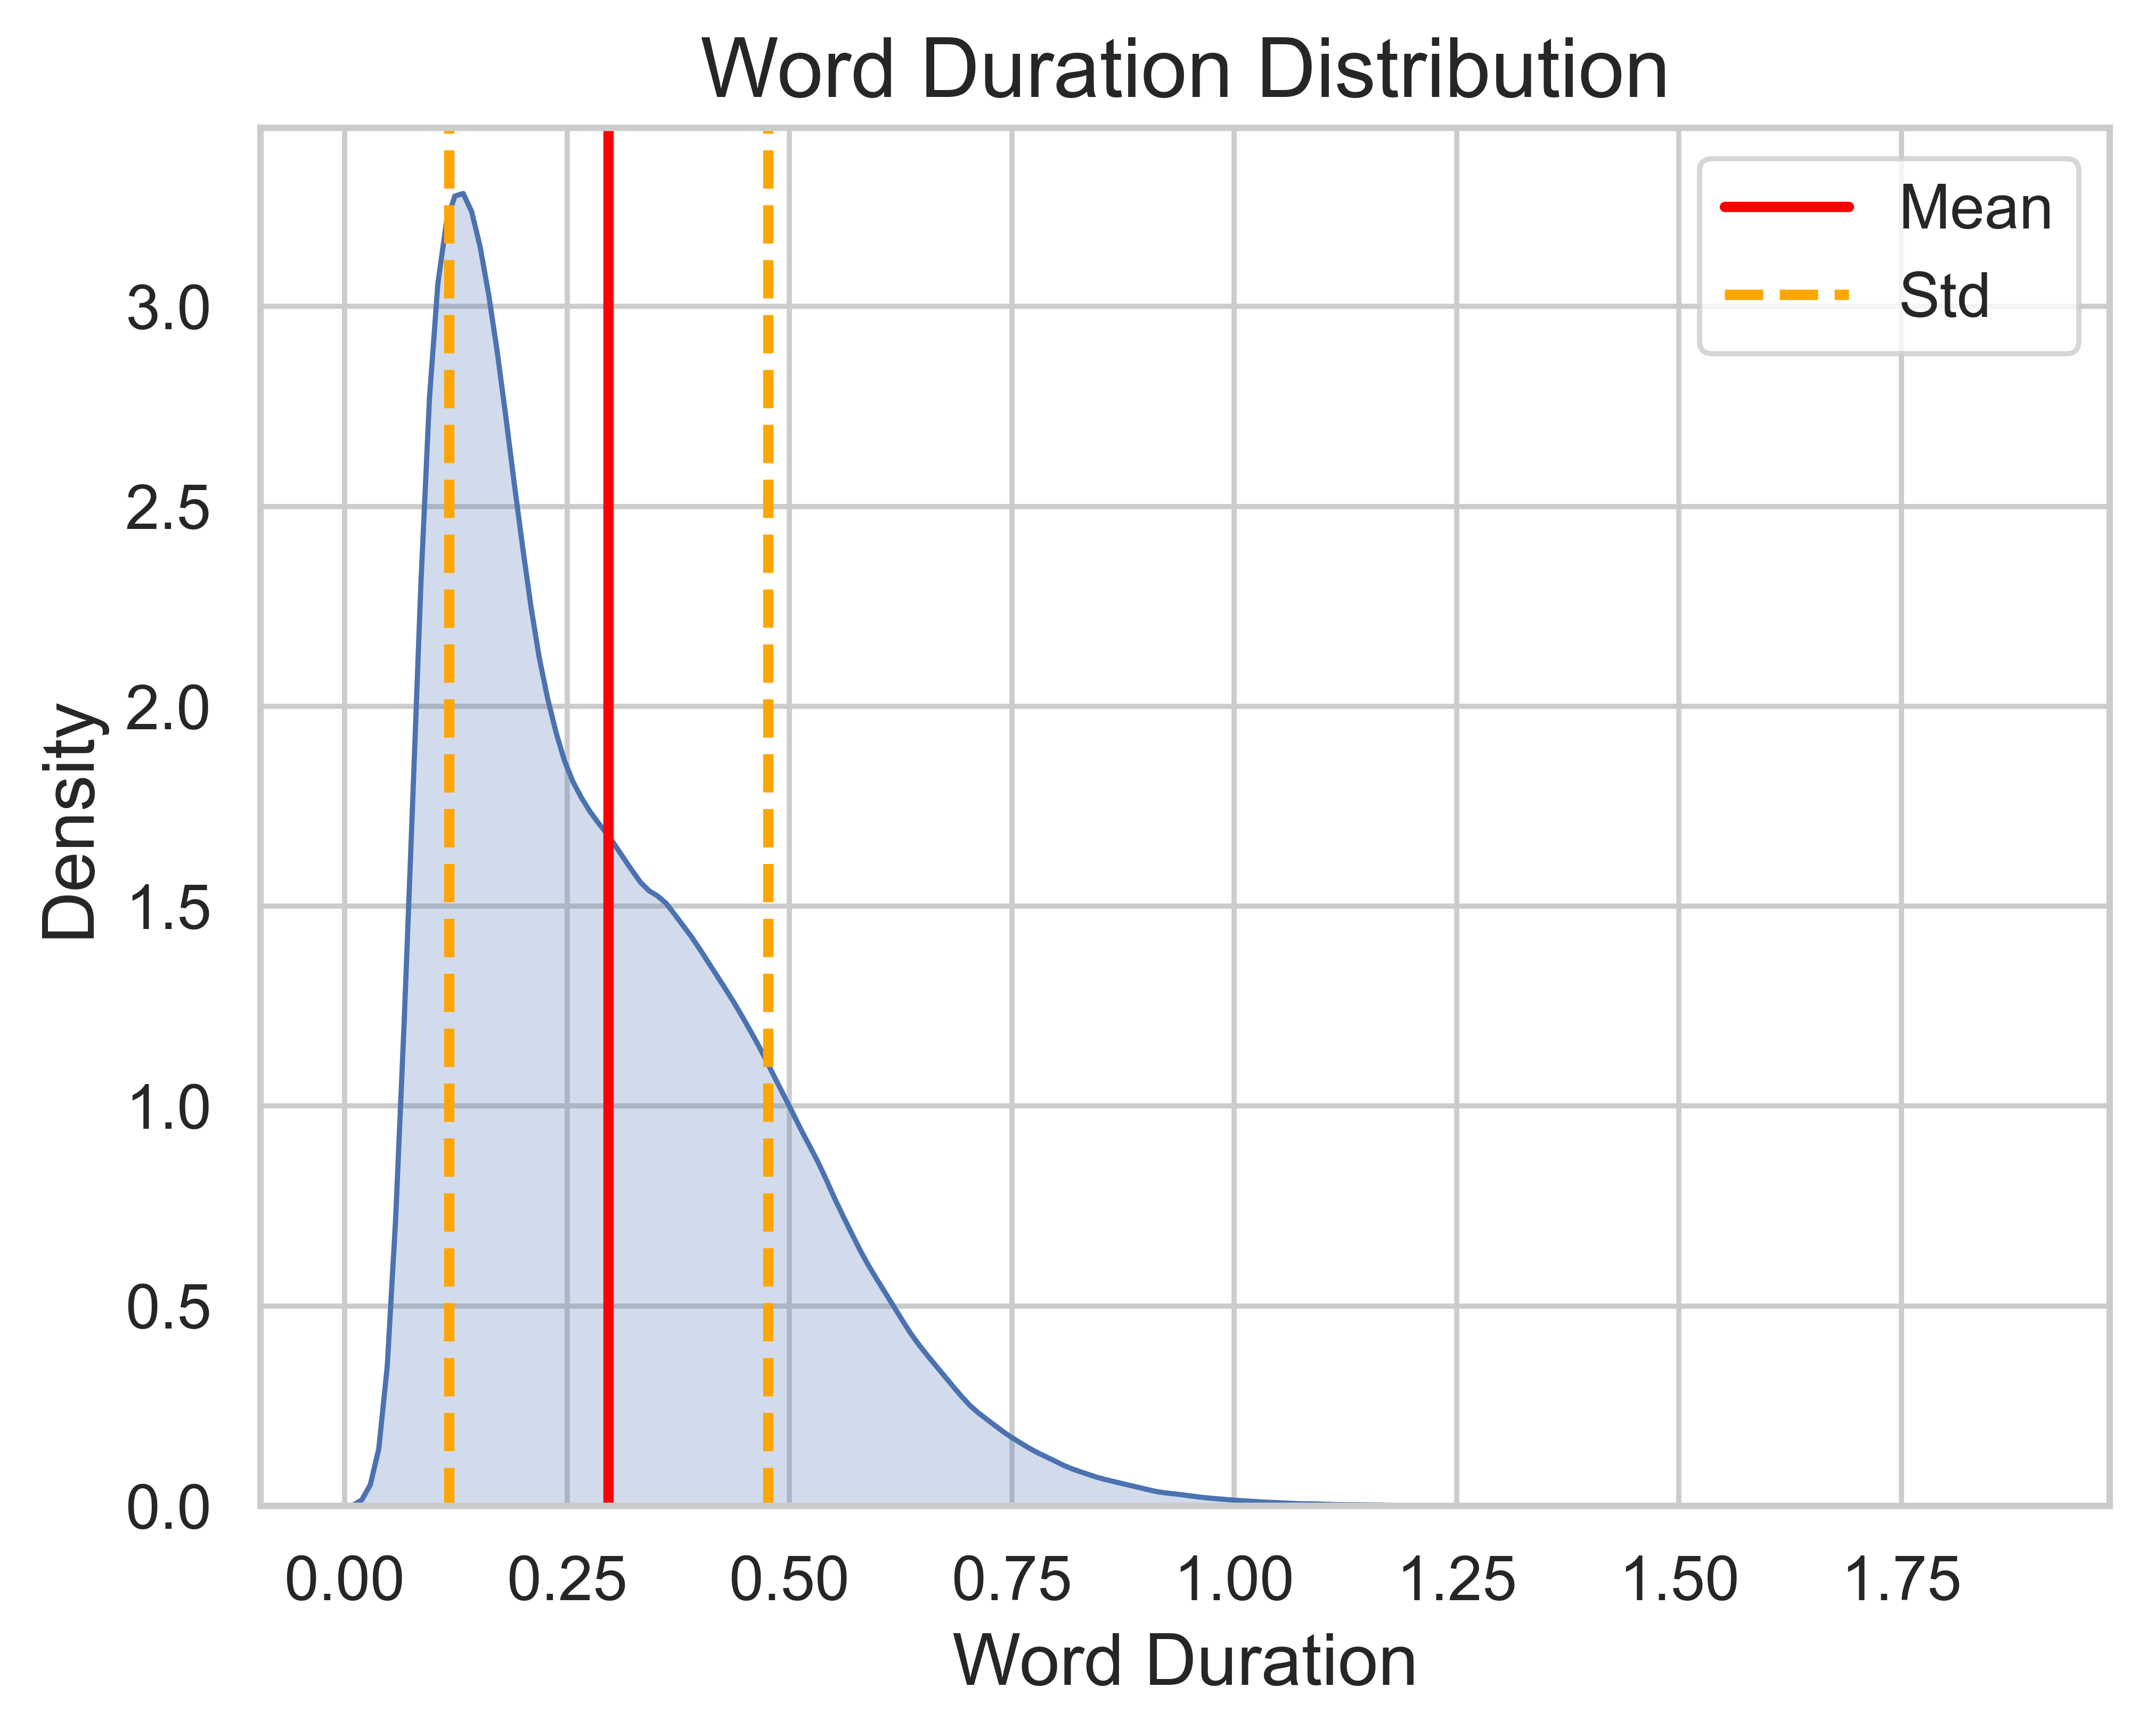

In [77]:
from src.utils.plots import plot_just_kde

plot_just_kde(durations, label_name="Word Duration", title="Word Duration Distribution")

In [78]:
TASK_NAME = "duration"

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    words, durations, test_size=0.33, random_state=42
)

## Simple Models

### Random predictions 

In [80]:
from src.models.baselines.dummy_models import DummyModel

dummy_model = DummyModel(y_train, nb_sig=3)
print(f"Dummy model ")

predictions = dummy_model.predict(len(X_test))

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f"Mean squared error: {mse}")

# compute r2
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R2 score: {r2}")

# compute pearson
from scipy.stats import pearsonr

pearson = pearsonr(y_test, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
from scipy.stats import spearmanr

spearman = spearmanr(y_test, predictions)
print(f"Spearman correlation: {spearman}")

# store predictions
dummy_test_predictions = dummy_model.predict(len(X_test))

# store predictions
import pickle
import os

os.makedirs(f"{SAVE_DIR}/dummy", exist_ok=True)

with open(f"{SAVE_DIR}/dummy/pred_dummy_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(dummy_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/dummy/texts_dummy_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(X_test, f)

# store labels
with open(f"{SAVE_DIR}/dummy/labels_dummy_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(y_test, f)

Dummy model 
Mean squared error: 0.10465314639926265
R2 score: -2.2533167813917663
Pearson correlation: PearsonRResult(statistic=0.002329446754165164, pvalue=0.06509145984448925)
Spearman correlation: SignificanceResult(statistic=0.00223879577799163, pvalue=0.07625438248227144)


### Avg of all word in corpus

In [81]:
avg_difference = np.mean(y_train)
print(f"Average duration: {avg_difference}")

# compute mse
from sklearn.metrics import mean_squared_error

predictions = [avg_difference] * len(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(y_test, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(y_test, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(y_test, predictions)
print(f"Spearman correlation: {spearman}")


# store predictions
avg_test_predictions = [avg_difference] * len(X_test)

# store predictions
import pickle

os.makedirs(f"{SAVE_DIR}/avg", exist_ok=True)

with open(f"{SAVE_DIR}/avg/pred_avg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(avg_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/avg/texts_avg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(X_test, f)

# store labels
with open(f"{SAVE_DIR}/avg/labels_avg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(y_test, f)

Average duration: 0.2965858371323633
Mean squared error: 0.03216813974445689
R2 score: -2.3482661370977098e-08
Pearson correlation: PearsonRResult(statistic=nan, pvalue=nan)
Spearman correlation: SignificanceResult(statistic=nan, pvalue=nan)


/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


### Corpus statistics: predict average diff per word 

In [82]:
# collect the words and their prominence scores
word_prominence = {}
for word, prominence in zip(X_train, y_train):
    if word not in word_prominence:
        word_prominence[word] = []
    word_prominence[word].append(prominence)

# compute the average prominence score for each word
word_prominence_avg = {}
for word, prominence in word_prominence.items():
    word_prominence_avg[word] = np.mean(prominence)

# for each word in the test set, get the average prominence score
predictions = []
for word in X_test:
    if word in word_prominence_avg:
        predictions.append(word_prominence_avg[word])
    else:
        predictions.append(avg_difference)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(y_test, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(y_test, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(y_test, predictions)
print(f"Spearman correlation: {spearman}")

# store predictions
word_test_predictions = []
for word in X_test:
    word_test_predictions.append(
        word_prominence_avg[word]
        if word in word_prominence_avg
        else GLOBAL_MEAN_DURATION
    )

# store predictions
import pickle

os.makedirs(f"{SAVE_DIR}/wordavg", exist_ok=True)

with open(f"{SAVE_DIR}/wordavg/pred_wordavg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(word_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/wordavg/texts_wordavg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(X_test, f)

# store labels
with open(f"{SAVE_DIR}/wordavg/labels_wordavg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(y_test, f)

Mean squared error: 0.007478197239381866
R2 score: 0.7675278249100973
Pearson correlation: PearsonRResult(statistic=0.8762835933701756, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.8903980135308038, pvalue=0.0)


## GloVe Embedding Baseline
#### Expects Embeddings already downloaded 

In [83]:
weight_dir = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/glove"

vocab, embeddings = [], []
with open(os.path.join(weight_dir, "glove.6B.300d.txt"), "rt") as fi:
    full_content = fi.read().strip().split("\n")
for i in range(len(full_content)):
    i_word = full_content[i].split(" ")[0]
    i_embeddings = [float(val) for val in full_content[i].split(" ")[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

In [84]:
import numpy as np

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

print(f"Shapes vocab: {vocab_npa.shape}  embeddings: {embs_npa.shape}")

Shapes vocab: (400000,)  embeddings: (400000, 300)


In [85]:
vocab_npa = np.insert(vocab_npa, 0, "<pad>")
vocab_npa = np.insert(vocab_npa, 1, "<unk>")
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1, embs_npa.shape[1]))  # embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True)  # embedding for '<unk>' token.

# insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa, unk_emb_npa, embs_npa))
print(embs_npa.shape)

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 300)


In [86]:
import torch

my_embedding_layer = torch.nn.Embedding.from_pretrained(
    torch.from_numpy(embs_npa).float()
)

assert my_embedding_layer.weight.shape == embs_npa.shape
print(my_embedding_layer.weight.shape)

torch.Size([400002, 300])


In [87]:
word_to_idx = {word: i for i, word in enumerate(vocab_npa)}
idx_to_word = {i: word for i, word in enumerate(vocab_npa)}

print(word_to_idx["house"])

168


In [88]:
# Create training and test data based on embedding of the word
train_data = []
for word in X_train:
    if word in word_to_idx:
        train_data.append(my_embedding_layer(torch.tensor(word_to_idx[word])))
    else:
        train_data.append(my_embedding_layer(torch.tensor(word_to_idx["<unk>"])))

test_data = []
for word in X_test:
    if word in word_to_idx:
        test_data.append(my_embedding_layer(torch.tensor(word_to_idx[word])))
    else:
        test_data.append(my_embedding_layer(torch.tensor(word_to_idx["<unk>"])))

print(
    f"Lengths of train and test set: {len(train_data)} and {len(test_data)}, respectively"
)

Lengths of train and test set: 1273132 and 627066, respectively


In [90]:
train_data = torch.stack(train_data)
test_data = torch.stack(test_data)

train_data.shape

torch.Size([1273132, 300])

In [91]:
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

train_labels.shape, test_labels.shape

(torch.Size([1273132]), torch.Size([627066]))

### GloVe: sklearn dummy regression

In [92]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(train_data, train_labels)

predictions = dummy_model.predict(test_data)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, predictions)
print(f"Mean squared error: {mse}")

Mean squared error: 0.03216814994812012


### GloVe: sklearn linear regression 

In [93]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(train_data, train_labels)

predictions = linear_model.predict(test_data)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(test_labels, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(test_labels, predictions)
print(f"Spearman correlation: {spearman}")

Mean squared error: 0.012038413435220718
R2 score: 0.6257659231875391
Pearson correlation: PearsonRResult(statistic=0.7910548773566929, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.8409659914572727, pvalue=0.0)


### GloVe: sklearn histgradboost

In [95]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_model = HistGradientBoostingRegressor(max_iter=300)
hist_model.fit(train_data, train_labels)

predictions = hist_model.predict(test_data)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(test_labels, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(test_labels, predictions)
print(f"Spearman correlation: {spearman}")

Mean squared error: 0.007459436034049624
R2 score: 0.768111047641783
Pearson correlation: PearsonRResult(statistic=0.876557342822034, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.8903847157196624, pvalue=0.0)


In [ ]:
from tqdm import tqdm

word_test_predictions = []
for word in tqdm(X_test, desc="Predicting test sentences", total=len(X_test)):
    if word in word_to_idx:
        word_test_predictions.append(
            my_embedding_layer(torch.tensor(word_to_idx[word]))
        )
    else:
        word_test_predictions.append(
            my_embedding_layer(torch.tensor(word_to_idx["<unk>"]))
        )

# store predictions
import pickle

os.makedirs(f"{SAVE_DIR}/glove_histgrad", exist_ok=True)

with open(f"{SAVE_DIR}/glove_histgrad/pred_glove_histgrad_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(word_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/glove_histgrad/texts_glove_histgrad_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(X_test, f)

# store labels
with open(
    f"{SAVE_DIR}/glove_histgrad/labels_glove_histgrad_{TASK_NAME}.pkl", "wb"
) as f:
    pickle.dump(y_test, f)

Predicting test sentences: 100%|██████████| 4822/4822 [02:07<00:00, 37.80it/s]
